Loading:
  Result_NW_15x15.txt | txt | raw shape=(15, 15)
  Hyb-Adam-UM_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  KNN_k12_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  patristic_ET-Impute_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  LRMC_Custom_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
Building NJ tree: Original
Building NJ tree: Hyb-Adam-UM
Building NJ tree: KNN-Impute (k=12)
Building NJ tree: ET-impute
Building NJ tree: LRMC


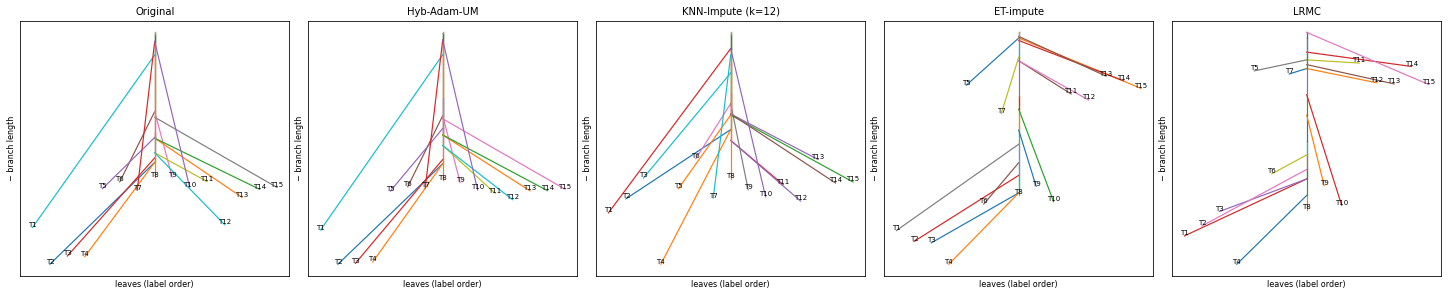

Saved: trees_row_joined.png


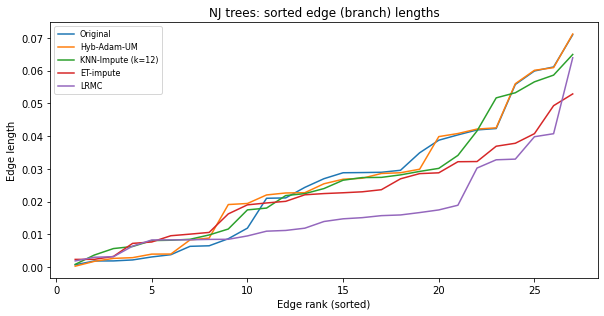

Saved: tree_edge_lengths_line.png


<Figure size 432x288 with 0 Axes>

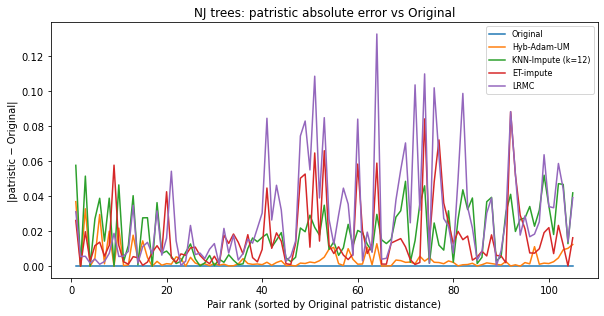

Saved: patristic_abs_error_line.png


<Figure size 432x288 with 0 Axes>

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Set, Tuple

# ============================================================
# I/O
# ============================================================
def load_matrix_any(path: str, fallback_labels=None, txt_autorescale=True):
    """
    Loads either:
      - CSV square matrix with row index + column headers
      - TXT whitespace-delimited numeric square matrix (no labels)
    Returns (M, labels, source_type)
    """
    ext = os.path.splitext(path)[1].lower()

    if ext in [".txt", ".dat"]:
        M = np.loadtxt(path, dtype=float)
        if M.ndim != 2:
            raise ValueError(f"{path}: expected 2D matrix, got shape {M.shape}")
        n, m = M.shape
        if n != m:
            raise ValueError(f"{path}: expected square matrix, got shape {M.shape}")

        # Heuristic rescale (keeps compatibility with your tree code)
        if txt_autorescale and np.nanmax(M) > 500:
            M = M / 1000.0

        if fallback_labels is None:
            labels = [f"t{i+1}" for i in range(n)]
        else:
            if len(fallback_labels) != n:
                raise ValueError(
                    f"{path}: label length {len(fallback_labels)} does not match matrix size {n}"
                )
            labels = list(fallback_labels)
        return M, labels, "txt"

    if ext == ".csv":
        last_err = None
        for sep in [",", ";", "\t"]:
            try:
                df = pd.read_csv(path, index_col=0, sep=sep, engine="python")
                df = df.apply(pd.to_numeric, errors="coerce")
                df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
                M = df.values.astype(float)
                labels = list(df.columns)
                if M.shape[1] == 0:
                    last_err = ValueError(f"Parsed 0 numeric columns with sep='{sep}'")
                    continue
                return M, labels, f"csv(sep='{sep}')"
            except Exception as e:
                last_err = e
                continue
        raise ValueError(f"Failed to parse CSV {path}. Last error: {last_err}")

    raise ValueError(f"Unsupported file extension for {path}")


# ============================================================
# SANITIZATION
# ============================================================
def _finite_fill(v, fallback: float = 1.0) -> float:
    v = np.asarray(v, dtype=float)
    vv = v[np.isfinite(v)]
    if vv.size > 0:
        return float(np.nanmedian(vv))
    return float(fallback)

def sanitize_distance_matrix(D: np.ndarray, force_nonneg: bool=True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2:
        raise ValueError(f"Matrix must be 2D, got shape {M.shape}")
    n, m = M.shape
    if n != m:
        raise ValueError(f"Matrix must be square, got shape {M.shape}")

    # Treat negative off-diagonal as missing
    neg = (M < 0)
    np.fill_diagonal(neg, False)
    M[neg] = np.nan

    off = ~np.eye(n, dtype=bool)
    med = _finite_fill(M[off], fallback=1.0)

    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)

    # Symmetrize + enforce constraints
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)

    if not np.isfinite(M).all():
        raise ValueError("Matrix has non-finite entries after sanitize.")
    return M


# ============================================================
# NJ TREE
# ============================================================
@dataclass
class NJTree:
    newick: str
    patristic: np.ndarray            # n x n leaf-to-leaf path lengths
    splits: Set[frozenset]           # unrooted splits (bipartitions) as leaf-label sets
    adj: Dict[int, Dict[int, float]] # weighted undirected adjacency
    root: int                        # arbitrary node chosen as root for drawing


def neighbor_joining_nonneg(D_full: np.ndarray, labels: List[str]) -> NJTree:
    D = sanitize_distance_matrix(D_full, force_nonneg=True)
    n = len(labels)
    if D.shape != (n, n):
        raise ValueError(f"Distance matrix shape {D.shape} does not match n={n} labels.")

    adj: Dict[int, Dict[int, float]] = {}

    def add_edge(u: int, v: int, w: float):
        w = float(max(w, 1e-9))
        adj.setdefault(u, {})
        adj.setdefault(v, {})
        adj[u][v] = w
        adj[v][u] = w

    next_id = n
    idx2node = {i: i for i in range(n)}
    act = list(range(n))
    Dv = D.copy()

    while len(act) > 2:
        m = len(act)
        r = np.sum(Dv, axis=1)
        r = np.nan_to_num(r, nan=_finite_fill(r, 1.0), posinf=_finite_fill(r, 1.0), neginf=_finite_fill(r, 1.0))

        Q = (m - 2) * Dv - r[:, None] - r[None, :]
        Q = np.nan_to_num(Q, nan=np.inf, posinf=np.inf, neginf=np.inf)
        np.fill_diagonal(Q, np.inf)

        if not np.isfinite(Q).any():
            Q = Dv.copy()
            np.fill_diagonal(Q, np.inf)

        a_idx, b_idx = np.unravel_index(np.argmin(Q), Q.shape)
        if a_idx > b_idx:
            a_idx, b_idx = b_idx, a_idx

        i, j = act[a_idx], act[b_idx]
        dij = float(Dv[a_idx, b_idx])

        li = 0.5 * dij + (r[a_idx] - r[b_idx]) / (2 * (m - 2))
        lj = dij - li
        if not np.isfinite(li): li = 0.5 * dij
        if not np.isfinite(lj): lj = 0.5 * dij

        u = next_id
        next_id += 1
        add_edge(u, idx2node[i], li)
        add_edge(u, idx2node[j], lj)

        duk = {}
        for k in range(m):
            if k in (a_idx, b_idx):
                continue
            val = 0.5 * (Dv[a_idx, k] + Dv[b_idx, k] - dij)
            if not np.isfinite(val):
                val = _finite_fill([Dv[a_idx, k], Dv[b_idx, k], dij], fallback=0.0)
            duk[k] = float(val)

        mask = np.ones(m, dtype=bool)
        mask[b_idx] = False
        Dv = Dv[np.ix_(mask, mask)]

        new_a = a_idx
        for t in range(m - 1):
            if t == new_a:
                Dv[new_a, t] = 0.0
                continue
            old_t = t if t < b_idx else t + 1
            Dv[new_a, t] = Dv[t, new_a] = duk.get(old_t, 0.0)

        Dv = np.maximum(0.5 * (Dv + Dv.T), 0.0)
        np.fill_diagonal(Dv, 0.0)

        idx2node[i] = u
        act.pop(b_idx)

    # final join
    i, j = act[0], act[1]
    add_edge(idx2node[i], idx2node[j], float(Dv[0, 1]))
    root = idx2node[i]

    # Newick (arbitrary rooting for output)
    def to_newick(x: int, parent: int = -1) -> str:
        if x < n:
            return labels[x]
        parts = []
        for v, w in adj.get(x, {}).items():
            if v == parent:
                continue
            parts.append(f"{to_newick(v, x)}:{w:.6f}")
        return "(" + ",".join(parts) + ")"

    newick = to_newick(root) + ";"

    # leaf-to-leaf patristic distances
    def path_len(a: int, b: int) -> float:
        stack = [(a, -1, 0.0)]
        seen = set()
        while stack:
            x, p, acc = stack.pop()
            if x == b:
                return acc
            seen.add(x)
            for y, w in adj.get(x, {}).items():
                if y == p or y in seen:
                    continue
                stack.append((y, x, acc + w))
        return np.nan

    P = np.zeros((n, n), dtype=float)
    for a in range(n):
        for b in range(a + 1, n):
            d = path_len(a, b)
            P[a, b] = P[b, a] = d

    # unrooted splits
    def compute_splits() -> Set[frozenset]:
        splits = set()
        seen_edges = set()
        for u in adj:
            for v in adj[u]:
                if (v, u) in seen_edges:
                    continue
                seen_edges.add((u, v))

                stack = [u]
                blocked = v
                visited = set([blocked])
                leafset = set()

                while stack:
                    x = stack.pop()
                    if x in visited:
                        continue
                    visited.add(x)
                    if x < n:
                        leafset.add(labels[x])
                    for y in adj.get(x, {}):
                        if y not in visited:
                            stack.append(y)

                if 1 < len(leafset) < n - 1:
                    splits.add(frozenset(sorted(leafset)))
        return splits

    splits = compute_splits()
    return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)


# ============================================================
# DRAW: NJ TREE INTO A GIVEN AXIS (so we can do 1 row of trees)
# ============================================================
def draw_nj_tree_ax(ax, nj: NJTree, labels: List[str], title: str):
    """
    Simple horizontal phylogram on provided axis.
      x-position: mean leaf index under each node
      y-position: - cumulative branch length from root
    """
    n = len(labels)
    x_leaf = {i: i for i in range(n)}
    y_pos: Dict[int, float] = {}

    def dfs(u: int, p: int = -1, y: float = 0.0):
        y_pos[u] = -y
        for v, w in nj.adj.get(u, {}).items():
            if v == p:
                continue
            dfs(v, u, y + w)

    dfs(nj.root, -1, 0.0)

    def leaf_span(node: int) -> float:
        if node < n:
            return float(x_leaf[node])
        seen = set()
        stack = [node]
        leaves = []
        while stack:
            x = stack.pop()
            if x in seen:
                continue
            seen.add(x)
            if x < n:
                leaves.append(x_leaf[x])
            else:
                for y in nj.adj.get(x, {}):
                    if y not in seen:
                        stack.append(y)
        return float(np.mean(leaves)) if leaves else 0.0

    drawn = set()
    for u in nj.adj:
        for v, w in nj.adj[u].items():
            if (v, u) in drawn:
                continue
            drawn.add((u, v))
            ax.plot([leaf_span(u), leaf_span(v)],
                    [y_pos.get(u, 0.0), y_pos.get(v, 0.0)],
                    linewidth=1.2)

    for i in range(n):
        ax.text(leaf_span(i), y_pos.get(i, 0.0), labels[i],
                ha="center", va="bottom", fontsize=7)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel("leaves (label order)", fontsize=8)
    ax.set_ylabel("− branch length", fontsize=8)
    ax.tick_params(labelsize=7)
    ax.set_xticks([])  # cleaner
    ax.set_yticks([])  # cleaner


# ============================================================
# LINE PLOT HELPERS
# ============================================================
def unique_edge_lengths(nj: NJTree) -> np.ndarray:
    """Return sorted unique edge lengths (undirected, one per edge)."""
    seen = set()
    lens = []
    for u in nj.adj:
        for v, w in nj.adj[u].items():
            if (v, u) in seen:
                continue
            seen.add((u, v))
            lens.append(float(w))
    lens = np.array(lens, dtype=float)
    lens = lens[np.isfinite(lens)]
    return np.sort(lens)

def upper_vec(M: np.ndarray) -> np.ndarray:
    iu = np.triu_indices(M.shape[0], k=1)
    v = np.asarray(M, float)[iu]
    v = v[np.isfinite(v)]
    return v


# ============================================================
# MAIN
# ============================================================

# ---- Put EXACTLY the 5 files you want (same as your heatmap code) ----
files = [
    "Result_NW_15x15.txt",
    "Hyb-Adam-UM_completed_p50_rep2.csv",
    "KNN_k12_completed_p50_rep2.csv",
    "patristic_ET-Impute_rep2.csv",
    "LRMC_Custom_completed_p50_rep2.csv",
]
titles = ["Original", "Hyb-Adam-UM", "KNN-Impute (k=12)","ET-impute", "LRMC"  ]

# ---- Load first labeled CSV as label source (same logic as before) ----
print("Loading:")
label_source = None
for p in files:
    if p.lower().endswith(".csv"):
        M0, labels0, src0 = load_matrix_any(p)
        label_source = labels0
        break

mats = []
labels_ref = None

for p in files:
    M_raw, labels, src = load_matrix_any(p, fallback_labels=label_source)
    print(f"  {os.path.basename(p)} | {src} | raw shape={M_raw.shape}")

    M = sanitize_distance_matrix(M_raw)

    if labels_ref is None:
        labels_ref = labels
    else:
        # realign if needed (for labeled CSV)
        if labels != labels_ref and p.lower().endswith(".csv"):
            df = pd.DataFrame(M, index=labels, columns=labels)
            missing = set(labels_ref) - set(labels)
            if missing:
                raise ValueError(f"{p}: missing labels {sorted(missing)}")
            df = df.loc[labels_ref, labels_ref]
            M = df.values
            labels = labels_ref

    mats.append(M)

# ---- Build NJ trees for each matrix ----
trees = []
for M, t in zip(mats, titles):
    print(f"Building NJ tree: {t}")
    trees.append(neighbor_joining_nonneg(M, labels_ref))

# ============================================================
# (A) PLOT TREES IN ONE ROW (in line)
# ============================================================
n = len(trees)
fig, axes = plt.subplots(1, n, figsize=(4.0 * n, 4.0), constrained_layout=True)
if n == 1:
    axes = [axes]

for ax, tree, t in zip(axes, trees, titles):
    draw_nj_tree_ax(ax, tree, labels_ref, t)

plt.show()
fig.savefig("trees_row_joined.png", dpi=300, bbox_inches="tight")
print("Saved: trees_row_joined.png")

# ============================================================
# (B) LINE PLOT: SORTED EDGE LENGTHS (branch lengths) COMPARISON
# ============================================================
plt.figure(figsize=(8.5, 4.5))
for tree, t in zip(trees, titles):
    el = unique_edge_lengths(tree)
    if el.size == 0:
        continue
    plt.plot(np.arange(1, el.size + 1), el, label=t)

plt.xlabel("Edge rank (sorted)")
plt.ylabel("Edge length")
plt.title("NJ trees: sorted edge (branch) lengths")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()
plt.savefig("tree_edge_lengths_line.png", dpi=300, bbox_inches="tight")
print("Saved: tree_edge_lengths_line.png")

# ============================================================
# (C) OPTIONAL: LINE PLOT OF PATRISTIC ABS ERROR VS ORIGINAL
#     (often more interpretable than edge lengths)
# ============================================================
DO_PATRISTIC_ERROR_LINE = True

if DO_PATRISTIC_ERROR_LINE:
    tref = trees[0]
    vref = upper_vec(tref.patristic)
    order = np.argsort(vref)

    plt.figure(figsize=(8.5, 4.5))
    for tree, t in zip(trees, titles):
        v = upper_vec(tree.patristic)
        m = min(v.size, vref.size)
        if m == 0:
            continue
        err = np.abs(v[:m] - vref[:m])
        # sort pairs by reference magnitude for a stable x-axis
        err = err[order[:m]]
        plt.plot(np.arange(1, m + 1), err, label=t)

    plt.xlabel("Pair rank (sorted by Original patristic distance)")
    plt.ylabel("|patristic − Original|")
    plt.title("NJ trees: patristic absolute error vs Original")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()
    plt.savefig("patristic_abs_error_line.png", dpi=300, bbox_inches="tight")
    print("Saved: patristic_abs_error_line.png")


Loading matrices:
  Result_NW_15x15.txt | txt | raw shape=(15, 15)
  Hyb-Adam-UM_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  KNN_k12_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  patristic_ET-Impute_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  LRMC_Custom_completed_p50_rep2.csv | csv(sep=',') | raw shape=(15, 15)
Building NJ tree: Original
Building NJ tree: Hyb-Adam-UM
Building NJ tree: KNN-Impute (k=12)
Building NJ tree: ET-impute
Building NJ tree: LRMC


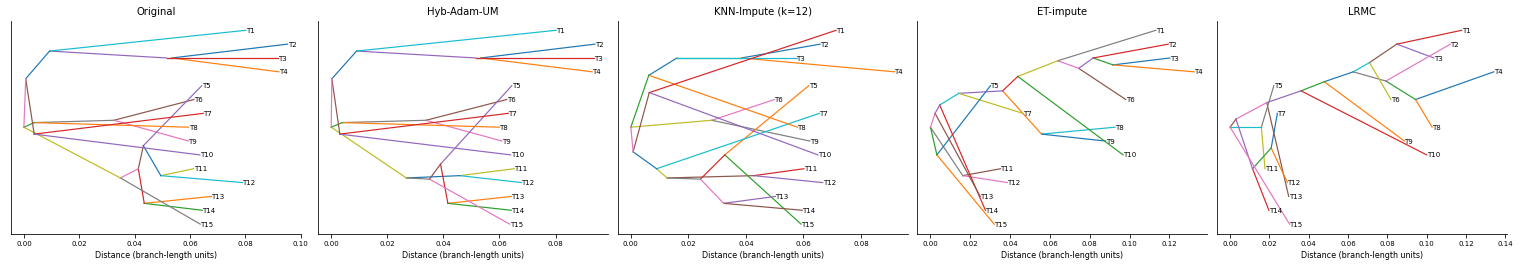

Saved: trees_row_joined.png


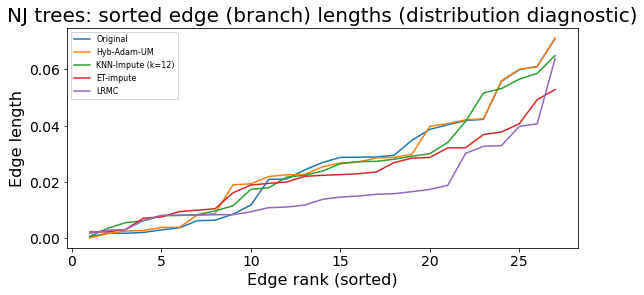

Saved: tree_edge_lengths_line.png


<Figure size 432x288 with 0 Axes>

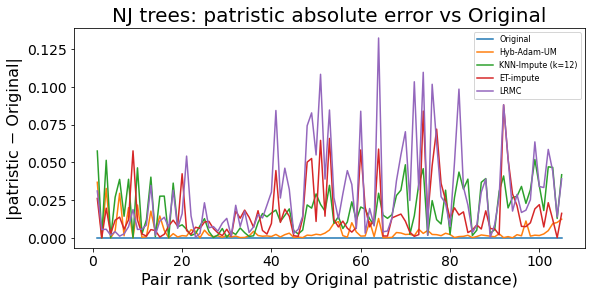

Saved: patristic_abs_error_line.png


<Figure size 432x288 with 0 Axes>

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Set, Tuple


# ============================================================
# CONFIG
# ============================================================
files = [
    "Result_NW_15x15.txt",
    "Hyb-Adam-UM_completed_p50_rep2.csv",
    "KNN_k12_completed_p50_rep2.csv",
    "patristic_ET-Impute_rep2.csv",
    "LRMC_Custom_completed_p50_rep2.csv",
]
titles = ["Original", "Hyb-Adam-UM", "KNN-Impute (k=12)", "ET-impute", "LRMC"]

OUT_TREES_ROW = "trees_row_joined.png"
OUT_EDGE_PROFILE = "tree_edge_lengths_line.png"
OUT_PATRISTIC_ERROR = "patristic_abs_error_line.png"

DO_EDGE_PROFILE = True          # sorted edge-length distribution
DO_PATRISTIC_ERROR_LINE = True  # |patristic - original| line plot


# ============================================================
# I/O HELPERS
# ============================================================
def load_matrix_any(path: str, fallback_labels=None, txt_autorescale=True):
    """
    Loads either:
      - CSV square matrix with row index + column headers
      - TXT whitespace-delimited numeric square matrix (no labels)
    Returns (M, labels, source_type)
    """
    ext = os.path.splitext(path)[1].lower()

    if ext in [".txt", ".dat"]:
        M = np.loadtxt(path, dtype=float)
        if M.ndim != 2:
            raise ValueError(f"{path}: expected 2D matrix, got shape {M.shape}")
        n, m = M.shape
        if n != m:
            raise ValueError(f"{path}: expected square matrix, got shape {M.shape}")

        # heuristic rescale (keeps compatibility with your other scripts)
        if txt_autorescale and np.nanmax(M) > 500:
            M = M / 1000.0

        if fallback_labels is None:
            labels = [f"t{i+1}" for i in range(n)]
        else:
            if len(fallback_labels) != n:
                raise ValueError(
                    f"{path}: label length {len(fallback_labels)} does not match matrix size {n}"
                )
            labels = list(fallback_labels)

        return M, labels, "txt"

    if ext == ".csv":
        last_err = None
        for sep in [",", ";", "\t"]:
            try:
                df = pd.read_csv(path, index_col=0, sep=sep, engine="python")
                df = df.apply(pd.to_numeric, errors="coerce")
                df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
                M = df.values.astype(float)
                labels = list(df.columns)
                if M.shape[1] == 0:
                    last_err = ValueError(f"Parsed 0 numeric columns with sep='{sep}'")
                    continue
                return M, labels, f"csv(sep='{sep}')"
            except Exception as e:
                last_err = e
                continue
        raise ValueError(f"Failed to parse CSV {path}. Last error: {last_err}")

    raise ValueError(f"Unsupported file extension for {path}")


# ============================================================
# SANITIZATION
# ============================================================
def _finite_fill(v, fallback: float = 1.0) -> float:
    v = np.asarray(v, dtype=float)
    vv = v[np.isfinite(v)]
    if vv.size > 0:
        return float(np.nanmedian(vv))
    return float(fallback)

def sanitize_distance_matrix(D: np.ndarray, force_nonneg: bool = True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError(f"Matrix must be square 2D, got shape {M.shape}")

    n = M.shape[0]

    # treat negative off-diagonal as missing
    neg = (M < 0)
    np.fill_diagonal(neg, False)
    M[neg] = np.nan

    off = ~np.eye(n, dtype=bool)
    med = _finite_fill(M[off], fallback=1.0)

    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)

    # symmetrize + constraints
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)

    if not np.isfinite(M).all():
        raise ValueError("Matrix has non-finite entries after sanitize.")
    return M


# ============================================================
# NJ TREE OBJECT
# ============================================================
@dataclass
class NJTree:
    newick: str
    patristic: np.ndarray            # n x n leaf-to-leaf path lengths
    splits: Set[frozenset]           # unrooted splits
    adj: Dict[int, Dict[int, float]] # weighted undirected adjacency
    root: int                        # chosen root for traversal/drawing


# ============================================================
# NEIGHBOR JOINING (nonnegative) + splits/patristic
# ============================================================
def neighbor_joining_nonneg(D_full: np.ndarray, labels: List[str]) -> NJTree:
    D = sanitize_distance_matrix(D_full, force_nonneg=True)
    n = len(labels)
    if D.shape != (n, n):
        raise ValueError(f"Distance matrix shape {D.shape} does not match n={n}.")

    adj: Dict[int, Dict[int, float]] = {}

    def add_edge(u: int, v: int, w: float):
        w = float(max(w, 1e-9))
        adj.setdefault(u, {})
        adj.setdefault(v, {})
        adj[u][v] = w
        adj[v][u] = w

    next_id = n
    idx2node = {i: i for i in range(n)}  # active index -> node id
    act = list(range(n))
    Dv = D.copy()

    while len(act) > 2:
        m = len(act)
        r = np.sum(Dv, axis=1)
        r = np.nan_to_num(r, nan=_finite_fill(r, 1.0), posinf=_finite_fill(r, 1.0), neginf=_finite_fill(r, 1.0))

        Q = (m - 2) * Dv - r[:, None] - r[None, :]
        Q = np.nan_to_num(Q, nan=np.inf, posinf=np.inf, neginf=np.inf)
        np.fill_diagonal(Q, np.inf)

        if not np.isfinite(Q).any():
            Q = Dv.copy()
            np.fill_diagonal(Q, np.inf)

        a_idx, b_idx = np.unravel_index(np.argmin(Q), Q.shape)
        if a_idx > b_idx:
            a_idx, b_idx = b_idx, a_idx

        i, j = act[a_idx], act[b_idx]
        dij = float(Dv[a_idx, b_idx])

        li = 0.5 * dij + (r[a_idx] - r[b_idx]) / (2 * (m - 2))
        lj = dij - li
        if not np.isfinite(li): li = 0.5 * dij
        if not np.isfinite(lj): lj = 0.5 * dij

        u = next_id
        next_id += 1
        add_edge(u, idx2node[i], li)
        add_edge(u, idx2node[j], lj)

        # distances from new node u to remaining nodes
        duk = {}
        for k in range(m):
            if k in (a_idx, b_idx):
                continue
            val = 0.5 * (Dv[a_idx, k] + Dv[b_idx, k] - dij)
            if not np.isfinite(val):
                val = _finite_fill([Dv[a_idx, k], Dv[b_idx, k], dij], fallback=0.0)
            duk[k] = float(val)

        # remove b_idx row/col; keep a_idx
        mask = np.ones(m, dtype=bool)
        mask[b_idx] = False
        Dv = Dv[np.ix_(mask, mask)]

        new_a = a_idx
        for t in range(m - 1):
            if t == new_a:
                Dv[new_a, t] = 0.0
                continue
            old_t = t if t < b_idx else t + 1
            Dv[new_a, t] = Dv[t, new_a] = duk.get(old_t, 0.0)

        Dv = np.maximum(0.5 * (Dv + Dv.T), 0.0)
        np.fill_diagonal(Dv, 0.0)

        idx2node[i] = u
        act.pop(b_idx)

    # final join
    i, j = act[0], act[1]
    add_edge(idx2node[i], idx2node[j], float(Dv[0, 1]))
    root = idx2node[i]

    # Newick (arbitrary rooting)
    def to_newick(x: int, parent: int = -1) -> str:
        if x < n:
            return labels[x]
        parts = []
        for v, w in adj.get(x, {}).items():
            if v == parent:
                continue
            parts.append(f"{to_newick(v, x)}:{w:.6f}")
        return "(" + ",".join(parts) + ")"

    newick = to_newick(root) + ";"

    # patristic distances
    def path_len(a: int, b: int) -> float:
        stack = [(a, -1, 0.0)]
        seen = set()
        while stack:
            x, p, acc = stack.pop()
            if x == b:
                return acc
            seen.add(x)
            for y, w in adj.get(x, {}).items():
                if y == p or y in seen:
                    continue
                stack.append((y, x, acc + w))
        return np.nan

    P = np.zeros((n, n), dtype=float)
    for a in range(n):
        for b in range(a + 1, n):
            d = path_len(a, b)
            P[a, b] = P[b, a] = d

    # splits (for RF etc., if needed later)
    def compute_splits() -> Set[frozenset]:
        splits = set()
        seen_edges = set()
        for u in adj:
            for v in adj[u]:
                if (v, u) in seen_edges:
                    continue
                seen_edges.add((u, v))

                stack = [u]
                blocked = v
                visited = set([blocked])
                leafset = set()

                while stack:
                    x = stack.pop()
                    if x in visited:
                        continue
                    visited.add(x)
                    if x < n:
                        leafset.add(labels[x])
                    for y in adj.get(x, {}):
                        if y not in visited:
                            stack.append(y)

                if 1 < len(leafset) < n - 1:
                    splits.add(frozenset(sorted(leafset)))
        return splits

    splits = compute_splits()
    return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)


# ============================================================
# DRAW: INFORMATIVE PHYLOGRAM
#   x-axis = distance from root (branch-length units, meaningful)
#   y-axis = taxa order (not meaningful; hide ticks/label)
# ============================================================
def draw_nj_tree_ax(ax, nj: NJTree, labels: List[str], title: str, add_scalebar=False):
    n = len(labels)

    # depth (distance from root)
    depth: Dict[int, float] = {}
    parent: Dict[int, int] = {}

    def dfs_depth(u: int, p: int = -1, d: float = 0.0):
        depth[u] = d
        parent[u] = p
        for v, w in nj.adj.get(u, {}).items():
            if v == p:
                continue
            dfs_depth(v, u, d + float(w))

    dfs_depth(nj.root, -1, 0.0)

    # leaf y positions: fixed label order (0..n-1)
    y_leaf = {i: float(i) for i in range(n)}

    # internal node y: mean of descendant leaf y's
    def descendant_leaf_ys(node: int, p: int = -1) -> List[float]:
        if node < n:
            return [y_leaf[node]]
        ys = []
        for v in nj.adj.get(node, {}):
            if v == p:
                continue
            ys.extend(descendant_leaf_ys(v, node))
        return ys

    y_node: Dict[int, float] = {}
    for u in nj.adj:
        ys = descendant_leaf_ys(u, parent.get(u, -1))
        y_node[u] = float(np.mean(ys)) if ys else 0.0

    # draw edges
    drawn = set()
    for u in nj.adj:
        for v, w in nj.adj[u].items():
            if (v, u) in drawn:
                continue
            drawn.add((u, v))
            ax.plot([depth[u], depth[v]], [y_node[u], y_node[v]], linewidth=1.2)

    # leaf labels
    for i in range(n):
        ax.text(depth.get(i, 0.0), y_node.get(i, y_leaf[i]),
                labels[i], ha="left", va="center", fontsize=7)

    ax.set_title(title, fontsize=10)

    # x-axis is meaningful: keep it, but keep it clean
    ax.set_xlabel("Distance (branch-length units)", fontsize=8)

    # y-axis is display order: hide ticks/label
    ax.set_yticks([])
    ax.set_ylabel("")

    # remove top/right spines for cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # invert y so taxa go top->bottom like many phylograms
    ax.invert_yaxis()

    # optional horizontal scale bar (now meaningful because x-axis is in distance units)
    if add_scalebar:
        maxd = float(np.nanmax(list(depth.values()))) if depth else 1.0
        if maxd <= 0:
            return

        raw = 0.2 * maxd
        p10 = 10 ** np.floor(np.log10(raw))
        bar = max(1e-9, round(raw / p10) * p10)

        # place in bottom-right corner
        x1 = maxd * 0.95
        x0 = x1 - bar
        y0 = n - 0.5  # near bottom (after invert_yaxis this still lands near bottom)

        ax.plot([x0, x1], [y0, y0], linewidth=2.0)
        ax.text((x0 + x1) / 2, y0 - 0.3, f"{bar:g}", ha="center", va="top", fontsize=7)

    ax.tick_params(axis="x", labelsize=7)


# ============================================================
# LINE-PLOT HELPERS
# ============================================================
def unique_edge_lengths(nj: NJTree) -> np.ndarray:
    seen = set()
    lens = []
    for u in nj.adj:
        for v, w in nj.adj[u].items():
            if (v, u) in seen:
                continue
            seen.add((u, v))
            lens.append(float(w))
    lens = np.array(lens, dtype=float)
    lens = lens[np.isfinite(lens)]
    return np.sort(lens)

def upper_vec(M: np.ndarray) -> np.ndarray:
    iu = np.triu_indices(M.shape[0], k=1)
    v = np.asarray(M, float)[iu]
    v = v[np.isfinite(v)]
    return v


# ============================================================
# LOAD MATRICES (with label alignment)
# ============================================================
print("Loading matrices:")
label_source = None
for p in files:
    if p.lower().endswith(".csv"):
        _, labels0, _ = load_matrix_any(p)
        label_source = labels0
        break

mats = []
labels_ref = None

for p in files:
    M_raw, labels, src = load_matrix_any(p, fallback_labels=label_source)
    print(f"  {os.path.basename(p)} | {src} | raw shape={M_raw.shape}")

    M = sanitize_distance_matrix(M_raw)

    if labels_ref is None:
        labels_ref = labels
    else:
        # realign labeled CSV matrices if needed
        if labels != labels_ref and p.lower().endswith(".csv"):
            df = pd.DataFrame(M, index=labels, columns=labels)
            missing = set(labels_ref) - set(labels)
            if missing:
                raise ValueError(f"{p}: missing labels {sorted(missing)}")
            df = df.loc[labels_ref, labels_ref]
            M = df.values
            labels = labels_ref

    mats.append(M)


# ============================================================
# BUILD TREES
# ============================================================
trees = []
for M, t in zip(mats, titles):
    print(f"Building NJ tree: {t}")
    trees.append(neighbor_joining_nonneg(M, labels_ref))


# ============================================================
# (A) PLOT TREES IN ONE ROW (clean, informative axes)
# ============================================================
n = len(trees)
fig, axes = plt.subplots(1, n, figsize=(4.2 * n, 3.6), constrained_layout=True)
if n == 1:
    axes = [axes]

for ax, tree, t in zip(axes, trees, titles):
    draw_nj_tree_ax(ax, tree, labels_ref, t, add_scalebar=False)

plt.show()
fig.savefig(OUT_TREES_ROW, dpi=300, bbox_inches="tight")
print(f"Saved: {OUT_TREES_ROW}")


# ============================================================
# (B) OPTIONAL: EDGE-LENGTH DISTRIBUTION (sorted)
# ============================================================
if DO_EDGE_PROFILE:
    plt.figure(figsize=(8.5, 4.5))
    for tree, t in zip(trees, titles):
        el = unique_edge_lengths(tree)
        if el.size == 0:
            continue
        plt.plot(np.arange(1, el.size + 1), el, label=t)

    plt.xlabel("Edge rank (sorted)")
    plt.ylabel("Edge length")
    plt.title("NJ trees: sorted edge (branch) lengths (distribution diagnostic)")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()
    plt.savefig(OUT_EDGE_PROFILE, dpi=300, bbox_inches="tight")
    print(f"Saved: {OUT_EDGE_PROFILE}")


# ============================================================
# (C) OPTIONAL: PATRISTIC ABS ERROR VS ORIGINAL (more interpretable)
# ============================================================
if DO_PATRISTIC_ERROR_LINE:
    tref = trees[0]
    vref = upper_vec(tref.patristic)
    order = np.argsort(vref)

    plt.figure(figsize=(8.5, 4.5))
    for tree, t in zip(trees, titles):
        v = upper_vec(tree.patristic)
        m = min(v.size, vref.size)
        if m == 0:
            continue
        err = np.abs(v[:m] - vref[:m])
        err = err[order[:m]]
        plt.plot(np.arange(1, m + 1), err, label=t)

    plt.xlabel("Pair rank (sorted by Original patristic distance)")
    plt.ylabel("|patristic − Original|")
    plt.title("NJ trees: patristic absolute error vs Original")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()
    plt.savefig(OUT_PATRISTIC_ERROR, dpi=300, bbox_inches="tight")
    print(f"Saved: {OUT_PATRISTIC_ERROR}")


Loading matrices:
  Result_NW_15x15.txt | txt | raw shape=(15, 15)
  HybAdamUM_completed_p65_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  MWstar_completed_p65_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  LRMC_completed_p65_rep2.csv | csv(sep=',') | raw shape=(15, 15)
  NJstar_STRICT_completed_p65_rep2.csv | csv(sep=',') | raw shape=(15, 15)
Building NJ tree: Reference
Building NJ tree: Hyb-Adam-UM
Building NJ tree: MW*
Building NJ tree: LRMC
Building NJ tree: NJ*


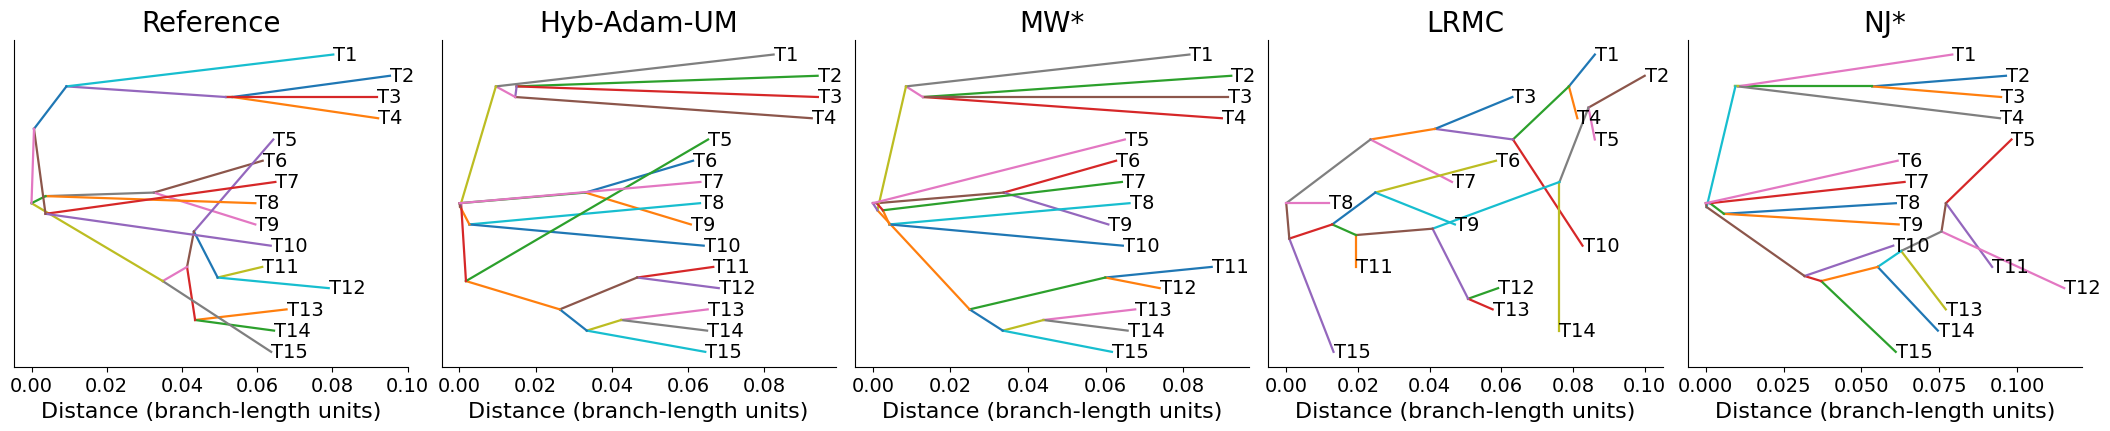

Saved: trees_row_joined.png


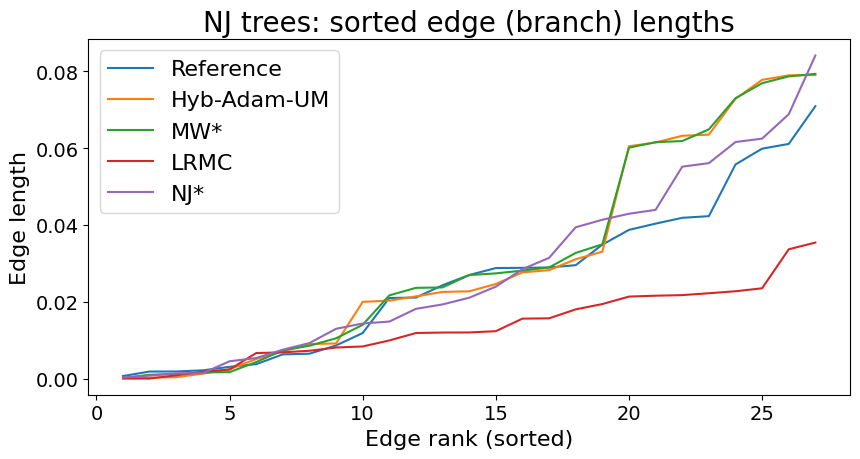

Saved: tree_edge_lengths_line.png


<Figure size 640x480 with 0 Axes>

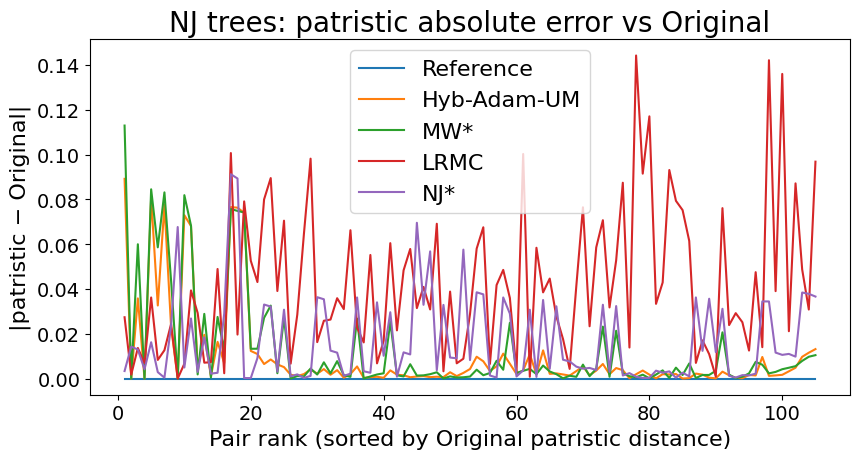

Saved: patristic_abs_error_line.png


<Figure size 640x480 with 0 Axes>

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Set, Tuple


# ============================================================
# CONFIG
# ============================================================
files = [
        "Result_NW_15x15.txt",
    "HybAdamUM_completed_p65_rep2.csv",
     "MWstar_completed_p65_rep2.csv",
    "LRMC_completed_p65_rep2.csv",
    "NJstar_STRICT_completed_p65_rep2.csv",
]
titles = ["Reference", "Hyb-Adam-UM", "MW*", "LRMC", "NJ*"]

OUT_TREES_ROW = "trees_row_joined.png"
OUT_EDGE_PROFILE = "tree_edge_lengths_line.png"
OUT_PATRISTIC_ERROR = "patristic_abs_error_line.png"

DO_EDGE_PROFILE = True
DO_PATRISTIC_ERROR_LINE = True

# Make text twice bigger
FONT_SCALE = 2.0

# Base sizes (will be multiplied by FONT_SCALE)
BASE_TAXON_FONTSIZE = 7
BASE_TITLE_FONTSIZE = 10
BASE_AXISLABEL_FONTSIZE = 8
BASE_TICK_FONTSIZE = 7
BASE_LEGEND_FONTSIZE = 8
BASE_SCALEBAR_FONTSIZE = 7


# Optional: also scale matplotlib defaults (helps legends/ticks)
plt.rcParams.update({
    "font.size": 10 * FONT_SCALE,
    "axes.titlesize": BASE_TITLE_FONTSIZE * FONT_SCALE,
    "axes.labelsize": BASE_AXISLABEL_FONTSIZE * FONT_SCALE,
    "xtick.labelsize": BASE_TICK_FONTSIZE * FONT_SCALE,
    "ytick.labelsize": BASE_TICK_FONTSIZE * FONT_SCALE,
    "legend.fontsize": BASE_LEGEND_FONTSIZE * FONT_SCALE,
})


# ============================================================
# I/O HELPERS
# ============================================================
def load_matrix_any(path: str, fallback_labels=None, txt_autorescale=True):
    ext = os.path.splitext(path)[1].lower()

    if ext in [".txt", ".dat"]:
        M = np.loadtxt(path, dtype=float)
        if M.ndim != 2:
            raise ValueError(f"{path}: expected 2D matrix, got shape {M.shape}")
        n, m = M.shape
        if n != m:
            raise ValueError(f"{path}: expected square matrix, got shape {M.shape}")

        if txt_autorescale and np.nanmax(M) > 500:
            M = M / 1000.0

        if fallback_labels is None:
            labels = [f"t{i+1}" for i in range(n)]
        else:
            if len(fallback_labels) != n:
                raise ValueError(
                    f"{path}: label length {len(fallback_labels)} does not match matrix size {n}"
                )
            labels = list(fallback_labels)

        return M, labels, "txt"

    if ext == ".csv":
        last_err = None
        for sep in [",", ";", "\t"]:
            try:
                df = pd.read_csv(path, index_col=0, sep=sep, engine="python")
                df = df.apply(pd.to_numeric, errors="coerce")
                df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")
                M = df.values.astype(float)
                labels = list(df.columns)
                if M.shape[1] == 0:
                    last_err = ValueError(f"Parsed 0 numeric columns with sep='{sep}'")
                    continue
                return M, labels, f"csv(sep='{sep}')"
            except Exception as e:
                last_err = e
                continue
        raise ValueError(f"Failed to parse CSV {path}. Last error: {last_err}")

    raise ValueError(f"Unsupported file extension for {path}")


# ============================================================
# SANITIZATION
# ============================================================
def _finite_fill(v, fallback: float = 1.0) -> float:
    v = np.asarray(v, dtype=float)
    vv = v[np.isfinite(v)]
    if vv.size > 0:
        return float(np.nanmedian(vv))
    return float(fallback)

def sanitize_distance_matrix(D: np.ndarray, force_nonneg: bool = True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError(f"Matrix must be square 2D, got shape {M.shape}")

    n = M.shape[0]

    neg = (M < 0)
    np.fill_diagonal(neg, False)
    M[neg] = np.nan

    off = ~np.eye(n, dtype=bool)
    med = _finite_fill(M[off], fallback=1.0)

    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)

    if not np.isfinite(M).all():
        raise ValueError("Matrix has non-finite entries after sanitize.")
    return M


# ============================================================
# NJ TREE OBJECT
# ============================================================
@dataclass
class NJTree:
    newick: str
    patristic: np.ndarray
    splits: Set[frozenset]
    adj: Dict[int, Dict[int, float]]
    root: int


# ============================================================
# NEIGHBOR JOINING (nonnegative) + splits/patristic
# ============================================================
def neighbor_joining_nonneg(D_full: np.ndarray, labels: List[str]) -> NJTree:
    D = sanitize_distance_matrix(D_full, force_nonneg=True)
    n = len(labels)
    if D.shape != (n, n):
        raise ValueError(f"Distance matrix shape {D.shape} does not match n={n}.")

    adj: Dict[int, Dict[int, float]] = {}

    def add_edge(u: int, v: int, w: float):
        w = float(max(w, 1e-9))
        adj.setdefault(u, {})
        adj.setdefault(v, {})
        adj[u][v] = w
        adj[v][u] = w

    next_id = n
    idx2node = {i: i for i in range(n)}
    act = list(range(n))
    Dv = D.copy()

    while len(act) > 2:
        m = len(act)
        r = np.sum(Dv, axis=1)
        r = np.nan_to_num(r, nan=_finite_fill(r, 1.0), posinf=_finite_fill(r, 1.0), neginf=_finite_fill(r, 1.0))

        Q = (m - 2) * Dv - r[:, None] - r[None, :]
        Q = np.nan_to_num(Q, nan=np.inf, posinf=np.inf, neginf=np.inf)
        np.fill_diagonal(Q, np.inf)

        if not np.isfinite(Q).any():
            Q = Dv.copy()
            np.fill_diagonal(Q, np.inf)

        a_idx, b_idx = np.unravel_index(np.argmin(Q), Q.shape)
        if a_idx > b_idx:
            a_idx, b_idx = b_idx, a_idx

        i, j = act[a_idx], act[b_idx]
        dij = float(Dv[a_idx, b_idx])

        li = 0.5 * dij + (r[a_idx] - r[b_idx]) / (2 * (m - 2))
        lj = dij - li
        if not np.isfinite(li): li = 0.5 * dij
        if not np.isfinite(lj): lj = 0.5 * dij

        u = next_id
        next_id += 1
        add_edge(u, idx2node[i], li)
        add_edge(u, idx2node[j], lj)

        duk = {}
        for k in range(m):
            if k in (a_idx, b_idx):
                continue
            val = 0.5 * (Dv[a_idx, k] + Dv[b_idx, k] - dij)
            if not np.isfinite(val):
                val = _finite_fill([Dv[a_idx, k], Dv[b_idx, k], dij], fallback=0.0)
            duk[k] = float(val)

        mask = np.ones(m, dtype=bool)
        mask[b_idx] = False
        Dv = Dv[np.ix_(mask, mask)]

        new_a = a_idx
        for t in range(m - 1):
            if t == new_a:
                Dv[new_a, t] = 0.0
                continue
            old_t = t if t < b_idx else t + 1
            Dv[new_a, t] = Dv[t, new_a] = duk.get(old_t, 0.0)

        Dv = np.maximum(0.5 * (Dv + Dv.T), 0.0)
        np.fill_diagonal(Dv, 0.0)

        idx2node[i] = u
        act.pop(b_idx)

    i, j = act[0], act[1]
    add_edge(idx2node[i], idx2node[j], float(Dv[0, 1]))
    root = idx2node[i]

    def to_newick(x: int, parent: int = -1) -> str:
        if x < n:
            return labels[x]
        parts = []
        for v, w in adj.get(x, {}).items():
            if v == parent:
                continue
            parts.append(f"{to_newick(v, x)}:{w:.6f}")
        return "(" + ",".join(parts) + ")"

    newick = to_newick(root) + ";"

    def path_len(a: int, b: int) -> float:
        stack = [(a, -1, 0.0)]
        seen = set()
        while stack:
            x, p, acc = stack.pop()
            if x == b:
                return acc
            seen.add(x)
            for y, w in adj.get(x, {}).items():
                if y == p or y in seen:
                    continue
                stack.append((y, x, acc + w))
        return np.nan

    P = np.zeros((n, n), dtype=float)
    for a in range(n):
        for b in range(a + 1, n):
            d = path_len(a, b)
            P[a, b] = P[b, a] = d

    def compute_splits() -> Set[frozenset]:
        splits = set()
        seen_edges = set()
        for u in adj:
            for v in adj[u]:
                if (v, u) in seen_edges:
                    continue
                seen_edges.add((u, v))

                stack = [u]
                blocked = v
                visited = set([blocked])
                leafset = set()

                while stack:
                    x = stack.pop()
                    if x in visited:
                        continue
                    visited.add(x)
                    if x < n:
                        leafset.add(labels[x])
                    for y in adj.get(x, {}):
                        if y not in visited:
                            stack.append(y)

                if 1 < len(leafset) < n - 1:
                    splits.add(frozenset(sorted(leafset)))
        return splits

    splits = compute_splits()
    return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)


# ============================================================
# DRAW: PHYLOGRAM WITH MEANINGFUL X-AXIS + BIG TEXT
# ============================================================
def draw_nj_tree_ax(ax, nj: NJTree, labels: List[str], title: str, add_scalebar=False):
    n = len(labels)

    tax_fs = BASE_TAXON_FONTSIZE * FONT_SCALE
    tit_fs = BASE_TITLE_FONTSIZE * FONT_SCALE
    lab_fs = BASE_AXISLABEL_FONTSIZE * FONT_SCALE
    tick_fs = BASE_TICK_FONTSIZE * FONT_SCALE
    sb_fs = BASE_SCALEBAR_FONTSIZE * FONT_SCALE

    depth: Dict[int, float] = {}
    parent: Dict[int, int] = {}

    def dfs_depth(u: int, p: int = -1, d: float = 0.0):
        depth[u] = d
        parent[u] = p
        for v, w in nj.adj.get(u, {}).items():
            if v == p:
                continue
            dfs_depth(v, u, d + float(w))

    dfs_depth(nj.root, -1, 0.0)

    y_leaf = {i: float(i) for i in range(n)}

    def descendant_leaf_ys(node: int, p: int = -1) -> List[float]:
        if node < n:
            return [y_leaf[node]]
        ys = []
        for v in nj.adj.get(node, {}):
            if v == p:
                continue
            ys.extend(descendant_leaf_ys(v, node))
        return ys

    y_node: Dict[int, float] = {}
    for u in nj.adj:
        ys = descendant_leaf_ys(u, parent.get(u, -1))
        y_node[u] = float(np.mean(ys)) if ys else 0.0

    drawn = set()
    for u in nj.adj:
        for v, w in nj.adj[u].items():
            if (v, u) in drawn:
                continue
            drawn.add((u, v))
            ax.plot([depth[u], depth[v]], [y_node[u], y_node[v]], linewidth=1.6)

    for i in range(n):
        ax.text(depth.get(i, 0.0), y_node.get(i, y_leaf[i]),
                labels[i], ha="left", va="center", fontsize=tax_fs)

    ax.set_title(title, fontsize=tit_fs)
    ax.set_xlabel("Distance (branch-length units)", fontsize=lab_fs)

    ax.set_yticks([])
    ax.set_ylabel("")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.invert_yaxis()
    ax.tick_params(axis="x", labelsize=tick_fs)

    if add_scalebar:
        maxd = float(np.nanmax(list(depth.values()))) if depth else 1.0
        if maxd > 0:
            raw = 0.2 * maxd
            p10 = 10 ** np.floor(np.log10(raw))
            bar = max(1e-9, round(raw / p10) * p10)

            x1 = maxd * 0.95
            x0 = x1 - bar
            y0 = n - 0.5
            ax.plot([x0, x1], [y0, y0], linewidth=3.0)
            ax.text((x0 + x1) / 2, y0 - 0.5, f"{bar:g}",
                    ha="center", va="top", fontsize=sb_fs)


# ============================================================
# LINE-PLOT HELPERS
# ============================================================
def unique_edge_lengths(nj: NJTree) -> np.ndarray:
    seen = set()
    lens = []
    for u in nj.adj:
        for v, w in nj.adj[u].items():
            if (v, u) in seen:
                continue
            seen.add((u, v))
            lens.append(float(w))
    lens = np.array(lens, dtype=float)
    lens = lens[np.isfinite(lens)]
    return np.sort(lens)

def upper_vec(M: np.ndarray) -> np.ndarray:
    iu = np.triu_indices(M.shape[0], k=1)
    v = np.asarray(M, float)[iu]
    v = v[np.isfinite(v)]
    return v


# ============================================================
# LOAD MATRICES (with label alignment)
# ============================================================
print("Loading matrices:")
label_source = None
for p in files:
    if p.lower().endswith(".csv"):
        _, labels0, _ = load_matrix_any(p)
        label_source = labels0
        break

mats = []
labels_ref = None

for p in files:
    M_raw, labels, src = load_matrix_any(p, fallback_labels=label_source)
    print(f"  {os.path.basename(p)} | {src} | raw shape={M_raw.shape}")

    M = sanitize_distance_matrix(M_raw)

    if labels_ref is None:
        labels_ref = labels
    else:
        if labels != labels_ref and p.lower().endswith(".csv"):
            df = pd.DataFrame(M, index=labels, columns=labels)
            missing = set(labels_ref) - set(labels)
            if missing:
                raise ValueError(f"{p}: missing labels {sorted(missing)}")
            df = df.loc[labels_ref, labels_ref]
            M = df.values
            labels = labels_ref

    mats.append(M)


# ============================================================
# BUILD TREES
# ============================================================
trees = []
for M, t in zip(mats, titles):
    print(f"Building NJ tree: {t}")
    trees.append(neighbor_joining_nonneg(M, labels_ref))


# ============================================================
# (A) PLOT TREES IN ONE ROW
# ============================================================
n = len(trees)
fig, axes = plt.subplots(1, n, figsize=(4.2 * n, 4.2), constrained_layout=True)
if n == 1:
    axes = [axes]

for ax, tree, t in zip(axes, trees, titles):
    draw_nj_tree_ax(ax, tree, labels_ref, t, add_scalebar=False)

plt.show()
fig.savefig(OUT_TREES_ROW, dpi=300, bbox_inches="tight")
print(f"Saved: {OUT_TREES_ROW}")


# ============================================================
# (B) OPTIONAL: EDGE-LENGTH DISTRIBUTION (sorted)
# ============================================================
if DO_EDGE_PROFILE:
    plt.figure(figsize=(9.0, 5.0))
    for tree, t in zip(trees, titles):
        el = unique_edge_lengths(tree)
        if el.size == 0:
            continue
        plt.plot(np.arange(1, el.size + 1), el, label=t)

    plt.xlabel("Edge rank (sorted)")
    plt.ylabel("Edge length")
    plt.title("NJ trees: sorted edge (branch) lengths")
    plt.legend(fontsize=BASE_LEGEND_FONTSIZE * FONT_SCALE)
    plt.tight_layout()
    plt.show()
    plt.savefig(OUT_EDGE_PROFILE, dpi=300, bbox_inches="tight")
    print(f"Saved: {OUT_EDGE_PROFILE}")


# ============================================================
# (C) OPTIONAL: PATRISTIC ABS ERROR VS ORIGINAL
# ============================================================
if DO_PATRISTIC_ERROR_LINE:
    tref = trees[0]
    vref = upper_vec(tref.patristic)
    order = np.argsort(vref)

    plt.figure(figsize=(9.0, 5.0))
    for tree, t in zip(trees, titles):
        v = upper_vec(tree.patristic)
        m = min(v.size, vref.size)
        if m == 0:
            continue
        err = np.abs(v[:m] - vref[:m])
        err = err[order[:m]]
        plt.plot(np.arange(1, m + 1), err, label=t)

    plt.xlabel("Pair rank (sorted by Original patristic distance)")
    plt.ylabel("|patristic − Original|")
    plt.title("NJ trees: patristic absolute error vs Original")
    plt.legend(fontsize=BASE_LEGEND_FONTSIZE * FONT_SCALE)
    plt.tight_layout()
    plt.show()
    plt.savefig(OUT_PATRISTIC_ERROR, dpi=600, bbox_inches="tight")
    print(f"Saved: {OUT_PATRISTIC_ERROR}")
